Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время

**Цель**  
Предсказать вероятность покупки в течение 90 дней.  

**Задачи**  
● Изучить данные  
● Разработать полезные признаки  
● Создать модель для классификации пользователей  
● Улучшить модель и максимизировать метрику roc_auc  
● Выполнить тестирование  

**Загрузим данные**

In [1]:
from IPython.display import display
import re
import datetime
from datetime import date, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV, 
    GridSearchCV
)
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder, 
    MinMaxScaler, 
    PolynomialFeatures
)
from sklearn.linear_model import (
    LogisticRegression
)
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix
)
from sklearn.svm import SVC
import seaborn as sns
import scipy.stats as st
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import phik
import shap
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import time
pd.set_option('display.max_columns', None)

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
messages = pd.read_csv('C:/Users/ASUS/Desktop/STD_M2_purchase_in_90_days/filtered_data/apparel-messages.csv')
purchases = pd.read_csv('C:/Users/ASUS/Desktop/STD_M2_purchase_in_90_days/filtered_data/apparel-purchases.csv')
target = pd.read_csv('C:/Users/ASUS/Desktop/STD_M2_purchase_in_90_days/filtered_data/apparel-target_binary.csv')
daily_event = pd.read_csv('C:/Users/ASUS/Desktop/STD_M2_purchase_in_90_days/filtered_data/full_campaign_daily_event.csv')
event_channel = (
    pd.read_csv('C:/Users/ASUS/Desktop/STD_M2_purchase_in_90_days/filtered_data/full_campaign_daily_event_channel.csv'))

**Изучим данные**

In [4]:
print(messages.shape)
print(purchases.shape)
target.shape

(12739798, 7)
(202208, 6)


(49849, 2)

In [5]:
print(messages.duplicated().sum())
print(purchases.duplicated().sum())
target.duplicated().sum()

48610
73020


0

In [6]:
print(purchases.duplicated().sum() / purchases.shape[0])
messages.duplicated().sum() / messages.shape[0]

0.36111330906789046


0.0038156020998135133

так как дубликатов в purchases 36%, то оставим данные. При анализе метрики показало, что есть дубликаты в purchases и messages, что нет, метриа не меняется

In [7]:
purchases = purchases.query(f'client_id in {target["client_id"].tolist()}')#.drop_duplicates()
messages = messages.query(f'client_id in {target["client_id"].tolist()}').drop_duplicates()

In [8]:
print(messages.bulk_campaign_id.unique().shape[0])
print(event_channel.bulk_campaign_id.unique().shape[0])
print(daily_event.bulk_campaign_id.unique().shape[0])

2706
3181
3181


In [9]:
purchases

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490


преобразуем в числа category_ids, чтобы посчитать их количество. Далее создадим 2 столбца: количество категорий в списке category_ids и всего купленных категорий( количество категорий в списке умножим на столбец quantity)

In [10]:
pd.to_numeric(re.findall(r'\d+', purchases.category_ids.iloc[0]))

array([  4,  28,  57, 431], dtype=int64)

In [11]:
a =[]
for i in purchases.category_ids:
    a.append(pd.to_numeric(re.findall(r'\d+', i)))

In [12]:
purchases["category_ids"] = a

In [13]:
purchases['len'] = purchases['category_ids'].apply(lambda x: len(x))

In [14]:
purchases['count_cat'] = purchases['quantity'] * purchases['len']
purchases

,client_id,quantity,price,category_ids,date,message_id,len,count_cat
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,4
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,4
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4
...,...,...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"[2, 18, 212, 726]",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,4,4
202204,1515915626010439406,1,99.0,"[4, 27, 233, 462]",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,4,4
202205,1515915626010439406,1,99.0,"[4, 27, 233, 462]",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,4,4
202206,1515915626010443527,1,1999.0,"[2, 18, 274, 446]",2024-02-16,1515915625766077627-14668-65cf5246bd490,4,4


In [15]:
# purchases[['cat_id_0','cat_id_1','cat_id_2','cat_id_3','cat_id_4']] = (
# pd.DataFrame(purchases.category_ids.tolist(), index= purchases.index))

создадим 2 столбца: laf - дата предыдущей покупки, days_off - сколько дней прошло от даты покупки до даты выгрузки. Так как дата выгрузки неизвестна, то возьмем в качестве отсечки самую последнюю дату среди всех покупок всех клиентов

In [16]:
purchases['date'] = pd.to_datetime(purchases['date'])
purchases['lag'] = purchases.sort_values(by='date', ascending=True).groupby('client_id')['date'].shift(1)
purchases['days_off'] = (purchases['date'].max()-purchases['date']).astype(str).str.replace('days','')
purchases['days_off'] = pd.to_numeric(purchases['days_off'], errors='coerce')

In [17]:
purchases

,client_id,quantity,price,category_ids,date,message_id,len,count_cat,lag,days_off
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,4,NaT,641
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,4,2022-05-16,641
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4,NaT,641
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4,2022-05-16,641
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4,2022-05-16,641
...,...,...,...,...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"[2, 18, 212, 726]",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,4,4,NaT,0
202204,1515915626010439406,1,99.0,"[4, 27, 233, 462]",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,4,4,NaT,0
202205,1515915626010439406,1,99.0,"[4, 27, 233, 462]",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,4,4,2024-02-16,0
202206,1515915626010443527,1,1999.0,"[2, 18, 274, 446]",2024-02-16,1515915625766077627-14668-65cf5246bd490,4,4,NaT,0


преобразуем lag как разницу в количестве дней между текущей покупкой и последней покупкой

In [18]:
def lags(col1,col2):
    if pd.isnull(col1):
        return pd.NaT
    else:
        return col2
purchases['lag'] = purchases.apply(lambda x: lags(x.date, x.lag), axis=1)
purchases['lag'] = (purchases['date'] - purchases['lag']).astype(str).str.replace('days','')
purchases['lag'] = pd.to_numeric(purchases['lag'], errors='coerce')

In [19]:
purchases

,client_id,quantity,price,category_ids,date,message_id,len,count_cat,lag,days_off
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,4,NaN,641
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,4,0.0,641
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4,NaN,641
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4,0.0,641
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4,0.0,641
...,...,...,...,...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"[2, 18, 212, 726]",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,4,4,NaN,0
202204,1515915626010439406,1,99.0,"[4, 27, 233, 462]",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,4,4,NaN,0
202205,1515915626010439406,1,99.0,"[4, 27, 233, 462]",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,4,4,0.0,0
202206,1515915626010443527,1,1999.0,"[2, 18, 274, 446]",2024-02-16,1515915625766077627-14668-65cf5246bd490,4,4,NaN,0


In [20]:
messages['message'] = messages['message_id'].apply(lambda x: x.split('-')[0])

In [21]:
purchases['message'] = purchases['message_id'].apply(lambda x: x.split('-')[0])

In [22]:
purchases['message'] = pd.to_numeric(purchases['message'], errors='coerce')

In [23]:
messages['message'] = pd.to_numeric(messages['message'], errors='coerce')

In [24]:
messages.query('client_id !=message')['client_id'].unique().shape

(0,)

In [25]:
purchases.query('client_id !=message')['client_id'].unique().shape

(12373,)

большое количество некорректно прикрепленных message_id за клиентами.удалять не будем? проставим np.nan

In [26]:
purchases.query('client_id !=message')['client_id']

28        1515915625684011633
29        1515915625730423268
30        1515915625776110064
31        1515915625776110064
372       1515915625535950983
                 ...         
202169    1515915626008613107
202204    1515915626010439406
202205    1515915626010439406
202206    1515915626010443527
202207    1515915626010443624
Name: client_id, Length: 55683, dtype: int64

In [27]:
purchases = purchases.drop(columns='message')
purchases

,client_id,quantity,price,category_ids,date,message_id,len,count_cat,lag,days_off
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,4,NaN,641
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,4,0.0,641
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4,NaN,641
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4,0.0,641
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4,0.0,641
...,...,...,...,...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"[2, 18, 212, 726]",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,4,4,NaN,0
202204,1515915626010439406,1,99.0,"[4, 27, 233, 462]",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,4,4,NaN,0
202205,1515915626010439406,1,99.0,"[4, 27, 233, 462]",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,4,4,0.0,0
202206,1515915626010443527,1,1999.0,"[2, 18, 274, 446]",2024-02-16,1515915625766077627-14668-65cf5246bd490,4,4,NaN,0


создадим 1-ю сводную таблицу с новыми признаками

In [28]:
p = purchases.groupby('client_id').agg({'quantity': ['count', 'sum'], 'price': ['sum' , 'median'],
                                'lag':'median', 'days_off': 'min', 'count_cat': ['count', 'median']})

In [29]:
column = []
for i in p.columns:
    column.append(i[0]+'_' + i[1])
p.columns = column
p = p.reset_index()
p

,client_id,quantity_count,quantity_sum,price_sum,price_median,lag_median,days_off_min,count_cat_count,count_cat_median
0,1515915625468060902,7,7,6993.0,999.0,0.0,630,7,4.0
1,1515915625468061003,7,7,16235.0,2100.0,0.0,408,7,4.0
2,1515915625468061099,1,1,299.0,299.0,NaN,640,1,4.0
3,1515915625468061100,2,2,2098.0,1049.0,0.0,6,2,4.0
4,1515915625468061170,19,19,33601.0,2195.0,0.0,244,19,4.0
...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,6,6,8994.0,1499.0,0.0,0,6,4.0
49845,1515915626010266132,2,2,1818.0,909.0,0.0,2,2,4.0
49846,1515915626010439406,2,2,198.0,99.0,0.0,0,2,4.0
49847,1515915626010443527,1,1,1999.0,1999.0,NaN,0,1,4.0


создадим столбец-, где 1-клиент обращался больше 1 раза и 0 где клиент покупал товар единожды.

In [30]:
p['reg_client'] = p['lag_median'].apply(lambda x: 1 if x >= 0  else 0)

In [31]:
p.lag_median.value_counts()

lag_median
0.0      34668
1.0        225
0.5        177
2.0         43
7.0         32
         ...  
357.0        1
94.5         1
238.5        1
335.0        1
221.0        1
Name: count, Length: 477, dtype: int64

создадим категорию в lag_median

In [32]:
def lag_medians(x):
    if 0<= x < 30:
        return 5
    elif 30<=x<90:
        return 4
    elif 90<=x<180:
        return 3
    elif 180<=x<365:
        return 2
    elif x>=365:
        return 1
    else:
        return 0
    

In [33]:
p['lag_median'] = p['lag_median'].apply(lambda x: lag_medians(x))

In [34]:
p

,client_id,quantity_count,quantity_sum,price_sum,price_median,lag_median,days_off_min,count_cat_count,count_cat_median,reg_client
0,1515915625468060902,7,7,6993.0,999.0,5,630,7,4.0,1
1,1515915625468061003,7,7,16235.0,2100.0,5,408,7,4.0,1
2,1515915625468061099,1,1,299.0,299.0,0,640,1,4.0,0
3,1515915625468061100,2,2,2098.0,1049.0,5,6,2,4.0,1
4,1515915625468061170,19,19,33601.0,2195.0,5,244,19,4.0,1
...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,6,6,8994.0,1499.0,5,0,6,4.0,1
49845,1515915626010266132,2,2,1818.0,909.0,5,2,2,4.0,1
49846,1515915626010439406,2,2,198.0,99.0,5,0,2,4.0,1
49847,1515915626010443527,1,1,1999.0,1999.0,0,0,1,4.0,0


переименуем столбец date для корректного join таблиц

In [35]:
messages.rename(columns={'date':'date_mes'}, inplace=True)
messages['date_mes'] = pd.to_datetime(messages['date_mes'])

In [36]:
df = messages.merge(purchases, on =['client_id', 'message_id'], how='outer')

In [37]:
# df['message'] = df['message_id'].apply(lambda x: x.split('-')[0])
# df['message'] = pd.to_numeric(df['message'], errors='coerce')
# def purchases_mess(column_1,column_2):
#     if column_1 != column_2:
#         return np.nan
#     else:
#         return column_1
# df['message_id'] = df.apply(lambda x: purchases_mess(x.client_id, x.message), axis=1)
# df = df.drop(columns='message')

In [38]:
df

,bulk_campaign_id,client_id,message_id,event,channel,date_mes,created_at,message,quantity,price,category_ids,date,len,count_cat,lag,days_off
0,10022.0,1515915625468060902,1515915625468060902-10022-63e5ededd911f,send,email,2023-02-10,2023-02-10 07:41:32,1.515916e+18,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,10218.0,1515915625468060902,1515915625468060902-10218-63ef56ed94656,send,email,2023-02-17,2023-02-17 10:30:29,1.515916e+18,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,10289.0,1515915625468060902,1515915625468060902-10289-63f35a8a9ff35,send,email,2023-02-20,2023-02-20 11:44:05,1.515916e+18,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,10373.0,1515915625468060902,1515915625468060902-10373-63f5cbba42484,send,email,2023-02-22,2023-02-22 08:13:16,1.515916e+18,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,10507.0,1515915625468060902,1515915625468060902-10507-63ff04f701e74,send,email,2023-03-01,2023-03-01 07:59:31,1.515916e+18,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11531234,NaN,1515915626010266132,1515915625999374481-14623-65c5c5acbad8c,NaN,NaN,NaT,NaN,NaN,1.0,909.0,"[4, 27, 278, 470]",2024-02-14,4.0,4.0,NaN,2.0
11531235,NaN,1515915626010439406,1515915625776605028-14662-65cf3abfe4f0d,NaN,NaN,NaT,NaN,NaN,1.0,99.0,"[4, 27, 233, 462]",2024-02-16,4.0,4.0,NaN,0.0
11531236,NaN,1515915626010439406,1515915625776605028-14662-65cf3abfe4f0d,NaN,NaN,NaT,NaN,NaN,1.0,99.0,"[4, 27, 233, 462]",2024-02-16,4.0,4.0,0.0,0.0
11531237,NaN,1515915626010443527,1515915625766077627-14668-65cf5246bd490,NaN,NaN,NaT,NaN,NaN,1.0,1999.0,"[2, 18, 274, 446]",2024-02-16,4.0,4.0,NaN,0.0


создадим столбец с разницей в кол-во дней между датой покупкой и датой отправки сообщения

In [39]:
df['days'] = (df['date'] -  df['date_mes']).astype(str).str.replace('days','')
df['days'] = pd.to_numeric(df['days'], errors='coerce')
df['days'] = df['days'].apply(lambda x: x if x>=0 else pd.NaT)

In [40]:
df['days'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 11531239 entries, 0 to 11531238
Series name: days
Non-Null Count   Dtype 
--------------   ----- 
742320 non-null  object
dtypes: object(1)
memory usage: 88.0+ MB


создадим 2-ю сводную таблицу и посчитаем количество действий с отправленными сообщениями.письмами

In [41]:
data = df.pivot_table(index='client_id',columns= ['channel','event'] ,
                      values = 'bulk_campaign_id', aggfunc='count').reset_index()


In [42]:
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41982 entries, 0 to 41981
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (client_id, )               41982 non-null  int64  
 1   (email, click)              41982 non-null  float64
 2   (email, complain)           41982 non-null  float64
 3   (email, hard_bounce)        41982 non-null  float64
 4   (email, hbq_spam)           41982 non-null  float64
 5   (email, open)               41982 non-null  float64
 6   (email, purchase)           41982 non-null  float64
 7   (email, send)               41982 non-null  float64
 8   (email, soft_bounce)        41982 non-null  float64
 9   (email, subscribe)          41982 non-null  float64
 10  (email, unsubscribe)        41982 non-null  float64
 11  (mobile_push, click)        41982 non-null  float64
 12  (mobile_push, close)        41982 non-null  float64
 13  (mobile_push, hard_bounce)  419

In [43]:
column = []
for i in data.columns:
    column.append(i[0]+'_' + i[1])
data.columns = column
data.rename(columns={'client_id_':'client_id'}, inplace=True)

In [44]:
k = df.pivot_table(index='client_id', values= 'message_id', aggfunc='count')
k.columns = ['messages_count']
k = k.reset_index()
k

,client_id,messages_count
0,1515915625468060902,243
1,1515915625468061003,189
2,1515915625468061099,277
3,1515915625468061100,432
4,1515915625468061170,364
...,...,...
49844,1515915626010261344,18
49845,1515915626010266132,2
49846,1515915626010439406,2
49847,1515915626010443527,1


объединим сводные таблицы

In [45]:
data = data.merge(k, on='client_id', how='outer')

In [46]:
data = data.merge(p, on='client_id', how='outer').merge(target, on='client_id')

In [47]:
data.columns

Index(['client_id', 'email_click', 'email_complain', 'email_hard_bounce',
       'email_hbq_spam', 'email_open', 'email_purchase', 'email_send',
       'email_soft_bounce', 'email_subscribe', 'email_unsubscribe',
       'mobile_push_click', 'mobile_push_close', 'mobile_push_hard_bounce',
       'mobile_push_open', 'mobile_push_purchase', 'mobile_push_send',
       'mobile_push_soft_bounce', 'messages_count', 'quantity_count',
       'quantity_sum', 'price_sum', 'price_median', 'lag_median',
       'days_off_min', 'count_cat_count', 'count_cat_median', 'reg_client',
       'target'],
      dtype='object')

In [48]:
data['ratio'] = data['quantity_count'] / data['messages_count']

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                49849 non-null  int64  
 1   email_click              41982 non-null  float64
 2   email_complain           41982 non-null  float64
 3   email_hard_bounce        41982 non-null  float64
 4   email_hbq_spam           41982 non-null  float64
 5   email_open               41982 non-null  float64
 6   email_purchase           41982 non-null  float64
 7   email_send               41982 non-null  float64
 8   email_soft_bounce        41982 non-null  float64
 9   email_subscribe          41982 non-null  float64
 10  email_unsubscribe        41982 non-null  float64
 11  mobile_push_click        41982 non-null  float64
 12  mobile_push_close        41982 non-null  float64
 13  mobile_push_hard_bounce  41982 non-null  float64
 14  mobile_push_open      

In [50]:
#messages.query('client_id == 1515915626010182877')
data.query('messages_count == 0')

,client_id,email_click,email_complain,email_hard_bounce,email_hbq_spam,email_open,email_purchase,email_send,email_soft_bounce,email_subscribe,email_unsubscribe,mobile_push_click,mobile_push_close,mobile_push_hard_bounce,mobile_push_open,mobile_push_purchase,mobile_push_send,mobile_push_soft_bounce,messages_count,quantity_count,quantity_sum,price_sum,price_median,lag_median,days_off_min,count_cat_count,count_cat_median,reg_client,target,ratio


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                49849 non-null  int64  
 1   email_click              41982 non-null  float64
 2   email_complain           41982 non-null  float64
 3   email_hard_bounce        41982 non-null  float64
 4   email_hbq_spam           41982 non-null  float64
 5   email_open               41982 non-null  float64
 6   email_purchase           41982 non-null  float64
 7   email_send               41982 non-null  float64
 8   email_soft_bounce        41982 non-null  float64
 9   email_subscribe          41982 non-null  float64
 10  email_unsubscribe        41982 non-null  float64
 11  mobile_push_click        41982 non-null  float64
 12  mobile_push_close        41982 non-null  float64
 13  mobile_push_hard_bounce  41982 non-null  float64
 14  mobile_push_open      

In [52]:
def dada(column):
    if column <= 0.0625:
        return '(~~, 0.0625]'
    elif 0.0625< column <= 0.2:
        return '(0.0625, 0.2]'
    elif 0.2 < column <= 0.25:
        return '(0.2, 0.25]'
    elif column > 0.25:
        return '[0.25, ~~]'
    elif column ==np.nan:
        return '[nan]'
data['ratio'] = data['ratio'].apply(lambda x: dada(x)).value_counts()

In [53]:
data = data.fillna(0)
data.replace([np.inf, -np.inf], 0, inplace=True)

C:\Users\ASUS\anaconda3\Lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable ratio for analysis 1. Dropping this column
  warnings.warn(


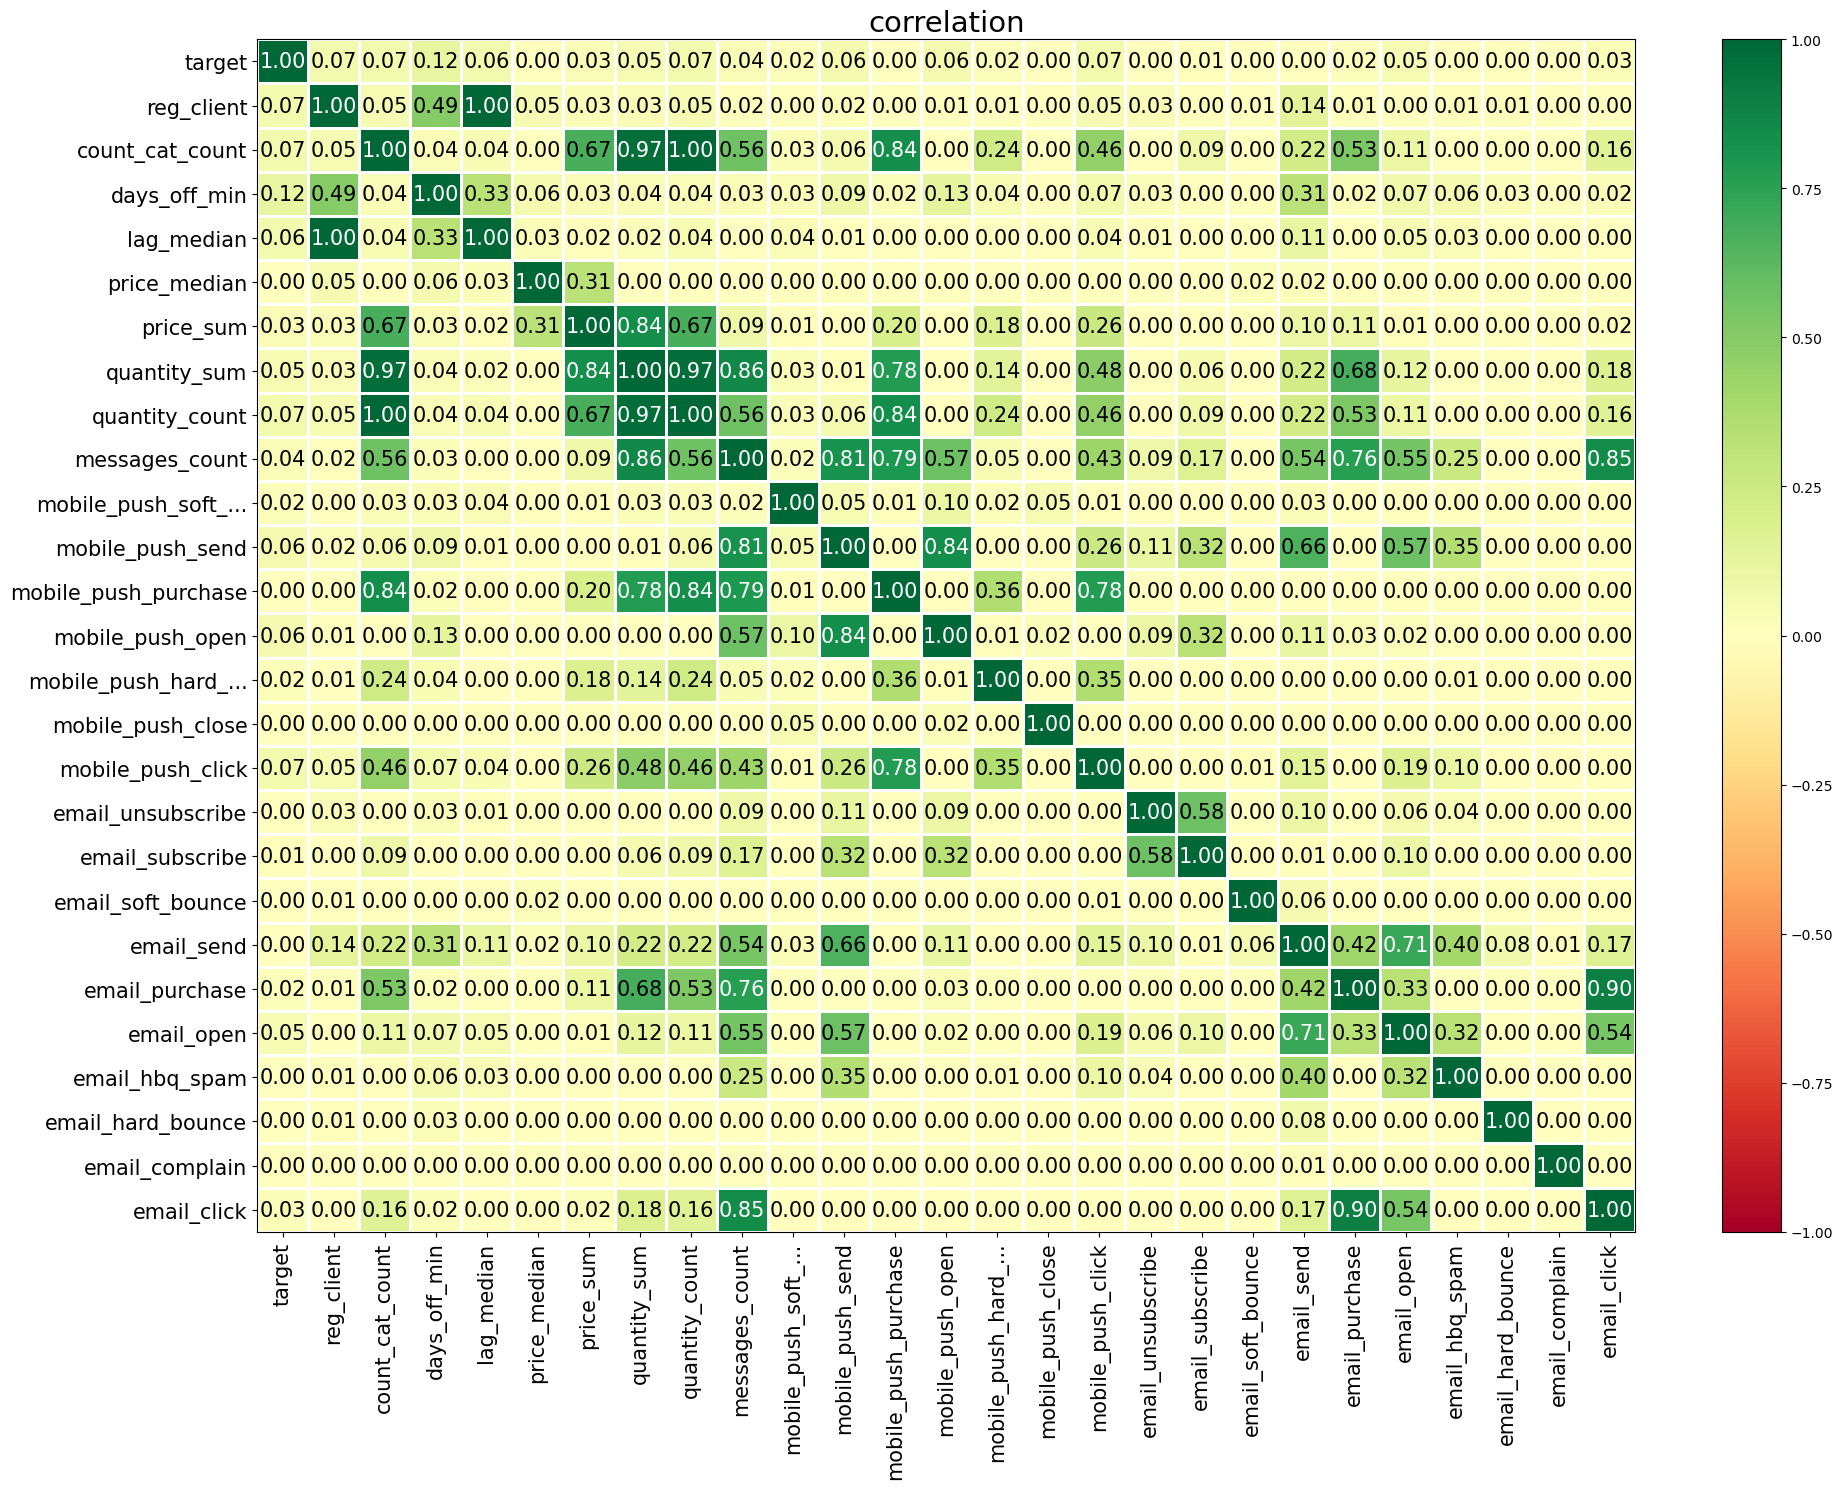

In [54]:
ha = data.drop(['client_id','count_cat_median'],axis= 1).copy()
num_columns = data.drop(['target','client_id', 'ratio','count_cat_median'], axis=1).columns.tolist()
phik_overview = ha.phik_matrix(interval_cols = num_columns)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(20, 15),
    fontsize_factor=1.5
);

мультиколлинеарность у таргета с признаками отсутствует, уберем в модели мультиколлинеарные признаки

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['target','client_id','count_cat_median','lag_median','count_cat_count', 'quantity_sum'], axis=1),
    data['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['target']
)

num_columns = data.drop(['target','client_id', 'ratio','count_cat_median','count_cat_count', \
                         'quantity_sum','lag_median',], axis=1).columns.tolist()
ohe_columns = ['ratio']

In [56]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

poly_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     #('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)#,
     #('poly', poly_pipe, poly_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state = RANDOM_STATE ))
])

In [57]:
param_grid = [
    
#     {
#        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')],
#        'models__max_depth': range(4,30),
#        'models__max_features': range(5,20),
#        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
#    },
   
   {
       'models': [LogisticRegression(
           random_state=RANDOM_STATE, 
           solver='liblinear', 
           penalty='l1',
           class_weight = 'balanced'
       )],
       'models__C': range(9,10),
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
   },
    {
        'models': [CatBoostClassifier(loss_function="Logloss", random_state=RANDOM_STATE)],
   #     'models__iterations': [150,200],
        'models__max_depth': [6, 10, 20, 30, 40, 50, 60],
        'models__n_estimators': [10, 20, 30, 40, 60]
    },
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')],
        'models__max_depth': [6, 10, 20, 30, 40, 50, 60],
        'models__n_estimators': [10, 20, 30, 40, 60]
        
    }#,
#    {
#       'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
#        'models__max_depth': [10, 20, 30, 40, 50, 60],
#        'models__n_estimators': [10, 20, 30, 40, 60]
#    }
]

In [58]:
start = time.time() 
grid = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid.fit(X_train, y_train)



display('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на кроссвалидационной выборке:', round(grid.best_score_,2))



grid_search_time = time.time() - start
print(f'Search time:{grid_search_time}')

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
125 fits failed out of a total of 365.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(

'Лучшая модель и её параметры:\n\n'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['ratio']),
                                                 ('num', 'passthrough',
                                                  ['email_click',
                                                   'email_complain',
                                                   'email_hard_bounce',
                                                   'email_hbq_...
                                                   'mobile_push_click',
                                                   'mobile_push_close',
                                                   'mobile_push_hard_bounce',
                                                   'mobile_push_open',
                                                   'mobile_push_purchase',
                                                   'mobile_push_send',
                                                   'mobile_push_soft_bounce',
                                                   'messages_count',
                                                   'quantity_count',
                                                   'price_sum', 'price_median',
                                                   'days_off_min',
                                                   'reg_client'])])),
                ('models',
                 LogisticRegression(C=9, class_weight='balanced', penalty='l1',
                                    random_state=42, solver='liblinear'))])

Метрика лучшей модели на кроссвалидационной выборке: 0.72
Search time:129.00727462768555


In [59]:
y_test_pred = grid.best_estimator_.predict_proba(X_test)[:,1]

In [60]:
roc_auc_score(y_test,y_test_pred)

0.7402092025961985

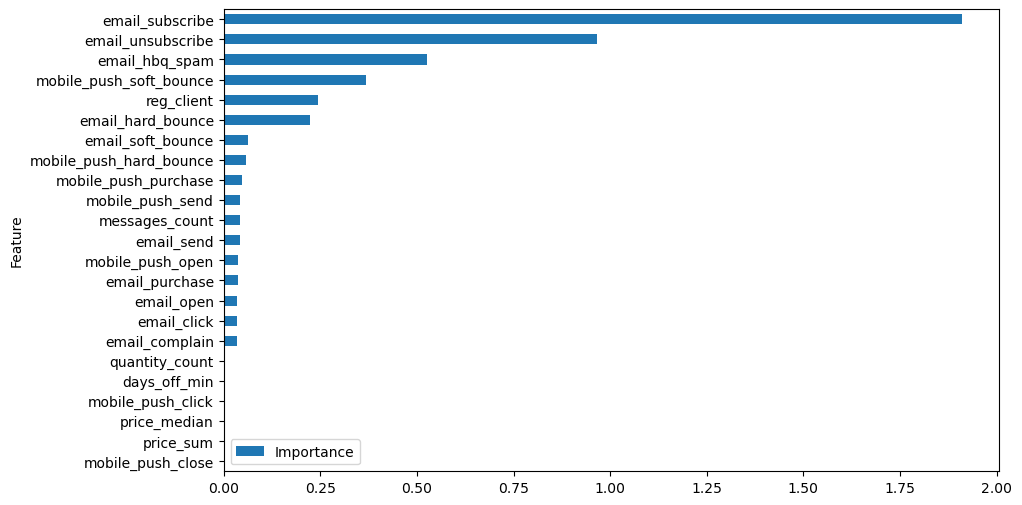

In [93]:
coefficients = grid.best_estimator_.named_steps['models'].coef_[0]
x= ['email_click', 'email_complain', 'email_hard_bounce', 'email_hbq_spam',
       'email_open', 'email_purchase', 'email_send', 'email_soft_bounce',
       'email_subscribe', 'email_unsubscribe', 'mobile_push_click',
       'mobile_push_close', 'mobile_push_hard_bounce', 'mobile_push_open',
       'mobile_push_purchase', 'mobile_push_send', 'mobile_push_soft_bounce',
       'messages_count', 'quantity_count', 'price_sum', 'price_median',
       'days_off_min', 'reg_client']
feature_importance = pd.DataFrame({'Feature': x, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Вывод

**Разработали модель для предсказаний.  
Лучшая модель: LogisticRegression(C=9, class_weight='balanced', penalty='l1', random_state=42,
                   solver='liblinear')
На предсказание прогноза вероятности покупки в течение 90 дней влияют такие признаки как email_subscribe,email_unsubscribe,  email_hbq_spam, mobile_push_click, reg_client(постоянный клиент/осуществил одну покупку **